In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!git clone https://github.com/acse-jy220/SFC-CAE-Ready-to-use

Cloning into 'SFC-CAE-Ready-to-use'...
remote: Enumerating objects: 1482, done.
remote: Counting objects: 100% (579/579), done.
remote: Compressing objects: 100% (333/333), done.
remote: Total 1482 (delta 354), reused 415 (delta 193), pack-reused 903
Receiving objects: 100% (1482/1482), 54.80 MiB | 49.57 MiB/s, done.
Resolving deltas: 100% (927/927), done.


In [ ]:
%cd SFC-CAE-Ready-to-use

/content/SFC-CAE-Ready-to-use


In [ ]:
!git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/acse-jy220/SFC-CAE-Ready-to-use
   58a8a3e..024548e  main       -> origin/main
Updating 58a8a3e..024548e
Fast-forward
 get_data_slugflow.sh | 8 +++++++-
 1 file changed, 7 insertions(+), 1 deletion(-)


In [ ]:
!pip install -e .

Obtaining file:///content/SFC-CAE-Ready-to-use
  Attempting uninstall: SFC-CAE
    Found existing installation: SFC-CAE 0.0.0
    Can't uninstall 'SFC-CAE'. No files were found to uninstall.
  Running setup.py develop for SFC-CAE


### The full slugflow dataset reachs **132** GB, I suggest train the full dataset over HPC, I attached a processed dataset (have been converted to binary `.pt` files) of 80 snapshots here, three space-filling curves are also provided here.

In [ ]:
! bash get_data_slugflow.sh

--2021-08-21 16:34:04--  https://www.dropbox.com/s/5j3i2jn2ggooagb/Slugflow_80.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5j3i2jn2ggooagb/Slugflow_80.zip [following]
--2021-08-21 16:34:04--  https://www.dropbox.com/s/raw/5j3i2jn2ggooagb/Slugflow_80.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc20dbfddfdeac5eea5f574ef87b.dl.dropboxusercontent.com/cd/0/inline/BUqH23TQ8dydi_WuoaYsUqyZhz27ZWkieQo6XHNjaDSsQvXWb84pFfFg2FbOROrOi7s9McueoNuuT1JZEYCFEQizGmm2JGHH2YWHFzAdT6HlkqQ1XgIwuYa1EHO1f3E8_TyeoEgqSmlc2UJnp7imxG1x/file# [following]
--2021-08-21 16:34:05--  https://uc20dbfddfdeac5eea5f574ef87b.dl.dropboxusercontent.com/cd/0/inline/BUqH23TQ8dydi_WuoaYsUqyZhz27ZWkieQo6XHNjaDSsQvXWb84pFfFg2FbOROrOi7s9McueoNuuT1JZE

In [ ]:
from sfc_cae import *

In [ ]:
path_data = glob.glob('slugflow_80/*')

In [ ]:
train_ratio = 15/17
valid_ratio = 1/17
test_ratio = 1/17
train_index, valid_index, test_index = index_split(train_ratio, valid_ratio, test_ratio, total_num = len(path_data))

train_index = train_index - 1
valid_index = valid_index - 1
test_index = test_index - 1

In [ ]:
len(train_index)

70

In [ ]:
full_set = MyTensorDataset(path_data, -1, 1)

  2% (2 of 80) |                         | Elapsed Time: 0:00:00 ETA:   0:00:04

Computing min and max......



100% (80 of 80) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


tk:  tensor([0.7881, 0.0679, 0.2529, 0.2036], dtype=torch.float64) 

tb:  tensor([-0.4057, -0.4814, -0.0091, -0.1309], dtype=torch.float64) 



In [ ]:
full_set.tk

tensor([0.7881, 0.0679, 0.2529, 0.2036], dtype=torch.float64)

In [ ]:
full_set.tb

tensor([-0.4057, -0.4814, -0.0091, -0.1309], dtype=torch.float64)

In [ ]:
full_set[0].shape

torch.Size([1342756, 4])

### Split train, valid, test dataset

In [ ]:
train_set, valid_set, test_set = torch.utils.data.dataset.random_split(full_set, [len(train_index), len(valid_index), len(test_index)])

In [ ]:
sfcs = torch.load('sfcs.pt').detach().numpy()
inv_sfcs = torch.load('inv_sfcs.pt').detach().numpy()
coords = torch.load('coords.pt').detach().numpy()

In [ ]:
space_filling_orderings, invert_space_filling_orderings = list(sfcs), list(inv_sfcs)

In [ ]:
input_size = coords.shape[0]
dimension = 3
components = 4
structured = False
self_concat = 1
nearest_neighbouring = False
dims_latent = 4
activation = nn.Tanh()

In [ ]:
batch_size = 16
lr = 1e-4
n_epoches = 2000
seed = 17
visualize = True

In [ ]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [ ]:
autoencoder = SFC_CAE(input_size,
                      dimension,
                      components,
                      structured,
                      self_concat,
                      nearest_neighbouring,
                      dims_latent,
                      space_filling_orderings[:3], 
                      invert_space_filling_orderings[:3],
                      activation = activation,
                      variational = False)

In [ ]:
autoencoder.output_structure()

The LaTeX script for the table structure of the SFC-CAE has been written to 'LatexTable.txt', please copy it to a LaTeX compiler environment, e.g. overleaf.


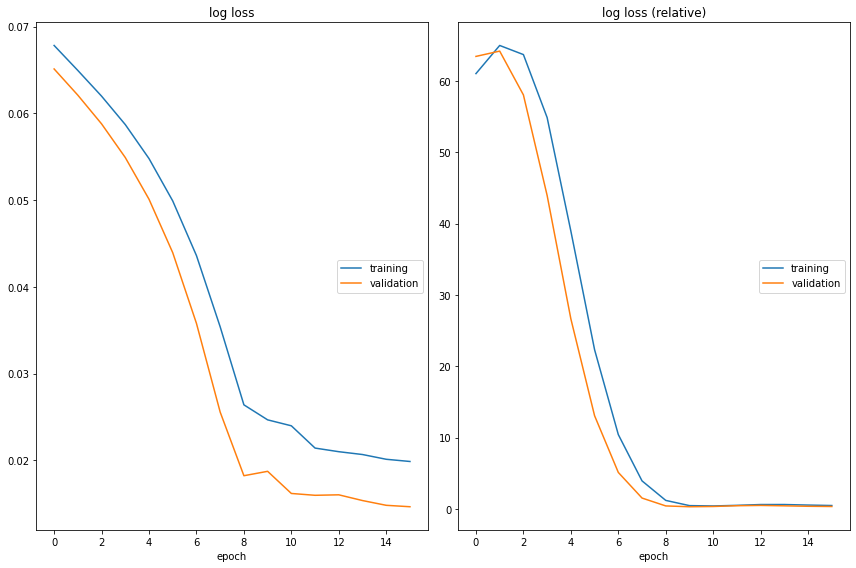

log loss
	training         	 (min:    0.020, max:    0.068, cur:    0.020)
	validation       	 (min:    0.015, max:    0.065, cur:    0.015)
log loss (relative)
	training         	 (min:    0.401, max:   64.985, cur:    0.461)
	validation       	 (min:    0.292, max:   64.195, cur:    0.325)
Epoch:  15 | train loss: 1.987063e-02 | valid loss: 1.465461e-02 
      	| train loss (relative): 4.610818e-01 | valid loss (relative): 3.254198e-01 
Epoch 15 use: 8.99 second.

epoch 16 starting......


KeyboardInterrupt: ignored

In [ ]:
autoencoder = train_model(autoencoder, 
                          train_loader = train_loader,
                          valid_loader = valid_loader,
                          test_loader = test_loader,
                          optimizer = 'Adamax',
                          state_load = None,
                          n_epochs = n_epoches,
                          varying_lr = False,
                          check_gap = 2, 
                          lr = lr, 
                          seed = seed,
                          visualize = visualize,
                          save_path = '/content/gdrive/MyDrive/Models/Slugflow/')